# Pre-Processing Pipeline for Character Trajectories Dataset  

## Overview

This notebook contains the code for importing the raw CharacterTrajectories dataset and preparing it for use with a torchcde, LSTM, and RNN implementation.

In [2]:
import os
from sktime.datasets import load_from_tsfile_to_dataframe
import numpy as np
import torch

# Load the data
train_X, train_y = load_from_tsfile_to_dataframe('../../data/raw//char_traj/CharacterTrajectories_TRAIN.ts')
test_X, test_y = load_from_tsfile_to_dataframe('../../data/raw/char_traj/CharacterTrajectories_TEST.ts')

# Convert to NumPy arrays
train_X = train_X.to_numpy()
test_X = test_X.to_numpy()

# Concatenate the data to form a single dataset
X = np.concatenate((train_X, test_X), axis=0)   # (batch, channel)
y = np.concatenate((train_y, test_y), axis=0)

# Change the labels to start from 0 and be integers
classes = np.unique(y)
y = np.array([np.where(classes == yi)[0][0] for yi in y])

In [3]:
def _pad(channel, maxlen):
    channel = torch.tensor(channel)
    mean_value = torch.mean(channel)
    out = torch.full((maxlen,), mean_value, dtype=channel.dtype)
    out[:channel.size(0)] = channel
    return out

# Pad all data to same size with zeros. To be corrected for torchcde
lengths = torch.tensor([len(Xi[0]) for Xi in X])
maxlen = lengths.max()

X = torch.stack([torch.stack([_pad(channel, maxlen) for channel in batch], dim=0) for batch in X], dim=0)
X = X.transpose(-1, -2)

In [4]:
# Normalize the data
mean = X.mean(dim=1, keepdim=True)
std = X.std(dim=1, keepdim=True)
X = (X - mean) / std

# Replace near zero values with zero
X[torch.abs(X) < 1e-5] = 0

In [5]:
# Add time as a channel
times = [np.linspace(0, lengths[i] - 1, lengths[i]) for i in range(len(X))]
for i, time in enumerate(times):
    padding = np.zeros(maxlen - len(time))
    times[i] = np.concatenate((time, padding))

times = torch.tensor(times)

X = torch.cat((times.unsqueeze(-1), X), dim=-1)

C:\Users\tanak\AppData\Local\Temp\ipykernel_9880\3901171844.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_6fueooay2f\croot\pytorch-select_1707342446212\work\torch\csrc\utils\tensor_new.cpp:278.)
  times = torch.tensor(times)


In [6]:
def create_labels(X, lengths):
    '''
    Create labels for the data. The data is the first
    2/3 of each sequence and the labels are the last 1/3.
    Sequences are padded with zeros to be the same length.

    Parameters
    ----------
    X : torch.Tensor
        The data of shape (batch, seq_length, channels).
    lengths : torch.Tensor
        The lengths of the sequences.

    Returns
    -------
    data : torch.Tensor
        The data of shape (batch, seq_length, channels).
    labels : torch.Tensor
        The labels of shape (batch, seq_length, channels).
    '''
    data = torch.zeros(X.size(0), X.size(1) * 2 // 3, X.size(2))
    labels = torch.zeros(X.size(0), X.size(1) * 1 // 3 + 1, X.size(2))

    for i in range(X.size(0)):
        # Pad datapoint with zeros
        datapoint = X[i, :lengths[i] * 2 // 3]
        padding = torch.zeros(X.size(1) * 2 // 3 - len(datapoint), X.size(2))
        datapoint = torch.cat((datapoint, padding))

        # Pad label with zeros
        label = X[i, lengths[i] * 2 // 3:lengths[i]]
        padding = torch.zeros(X.size(1) * 1 // 3 - len(label) + 1, X.size(2))
        label = torch.cat((label, padding))
        
        data[i] = datapoint
        labels[i] = label

    return data, labels

data, labels = create_labels(X, lengths)

In [7]:
# Split the data into a 80-20 train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=y)

# Save the data
path = '../../data/processed/CharacterTrajectories/regression/'
os.makedirs(path, exist_ok=True)
torch.save(X_train, os.path.join(path, 'X_train.pt'))
torch.save(y_train, os.path.join(path, 'y_train.pt'))
torch.save(X_test, os.path.join(path, 'X_test.pt'))
torch.save(y_test, os.path.join(path, 'y_test.pt'))

In [ ]:
def insert_random_missingness(X, y, missing_rate):
    '''
    Insert random missingness into the data.
    Only the first 120 sequence elements will be affected (avg length of 120).

    Parameters
    ----------
    X : np.array
        The input data. Shape (n_samples, sequence_length, n_features)
    y : np.array
        The target data. Shape (n_samples,)
    missing_rate : float
        The rate of missingness to insert in sequences of the samples. 
        Each sample in X will have this proportion of its sequence (each feature)
        set to NaN. 
    '''
    n_samples, _, _ = X.shape

    # Generate a mask of missingness 
    mask = np.random.rand(n_samples, 182) < missing_rate

    print(mask.shape)

    # Set the missing values to NaN
    X[mask] = np.nan

insert_random_missingness(X, y, 0.1)

# Visualize missing data

917
4
[  0.           0.          -0.31799116  -0.69751089  -1.14003816
  -1.14003816  -1.69869952  -1.69869952  -2.3823436   -3.14317627
  -3.9946332   -4.95011798  -4.95011798  -6.14083032  -7.45289402
  -8.88308976 -10.42573458 -12.0737684  -13.81923757 -13.81923757
 -15.73362361 -17.71873716 -19.76340709 -21.85191939 -21.85191939
 -21.85191939 -23.89501742 -23.89501742 -23.89501742 -23.89501742
 -25.24213954 -26.32074594 -27.11518895 -27.11518895 -27.34775982
 -27.3283588  -27.08962703 -26.6684944  -26.10067758 -26.10067758
 -25.3225145  -24.46533311 -24.46533311 -24.46533311 -23.40028261
 -23.40028261 -22.19085609 -20.90988043 -20.90988043 -19.51208069
 -18.07982341 -16.63434825 -15.19930227 -13.79985666 -12.46180526
 -11.21023291 -10.06791775  -9.05418332  -9.05418332  -8.33927974
  -8.33927974  -8.33927974  -8.09737874  -7.99876107  -8.03392813
  -8.1966361   -8.4846043   -8.89812336  -9.43833658 -10.10633371
 -10.90213359 -11.82239785 -11.82239785 -12.95580146 -14.16379237
 -15

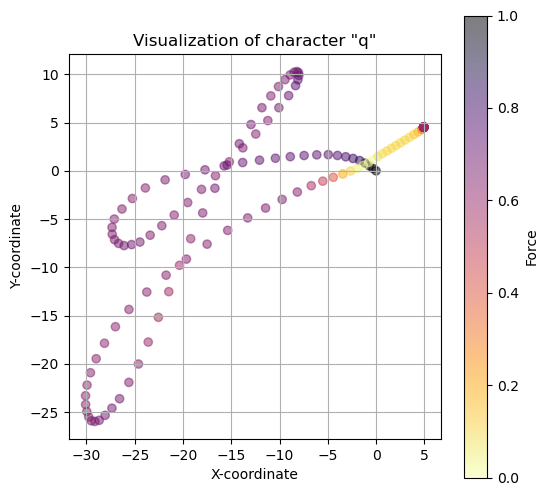

In [30]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm 
import random

#index = random.randint(0, 2857) # between 0 - 2857
index = 917
print(index)
print(y[index])

# Dictionary mapping index to characters
index_to_character = {
    0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'g', 6: 'h', 7: 'l', 8: 'm', 9: 'n',
    10: 'o', 11: 'p', 12: 'q', 13: 'r', 14: 's', 15: 'u', 16: 'v', 17: 'w', 18: 'y', 19: 'z'
}

x_velocities = X[index, : , 1].cpu().numpy()
y_velocities = X[index, : , 2].cpu().numpy()
force_values = X[index, : , 3].cpu().numpy()

# Create masks for missing data
missing_x = np.isnan(x_velocities)
missing_y = np.isnan(y_velocities)

# Integrate velocities to get positions, replacing NaN values with 0
x_positions = np.nancumsum(np.where(missing_x, 0, x_velocities))
y_positions = np.nancumsum(np.where(missing_y, 0, y_velocities))

# Remove last element and insert 0 to the beginning
x_positions = np.insert(x_positions[:-1],0,0)
y_positions = np.insert(y_positions[:-1],0,0)

# Handle NaN values by only considering non-NaN values for normalization
non_nan_values = force_values[~np.isnan(force_values)]
min_value = non_nan_values.min()
max_value = non_nan_values.max()

# Normalize non-NaN values
force_values_normalized = (force_values - min_value) / (max_value - min_value)

print(x_positions)

#character = index_to_character.get(y[index])
character = 'q'
'''
# Iterate over each point and draw the pen strokes
for i in range(len(x_values) - 1):
    plt.plot([x_positions[i], x_positions[i+1]], [y_positions[i], y_values[i+1]], 
         linewidth=1 + 4 * force_values_normalized[i].item(),  # Adjust line width based on force value
         color='blue')
'''

plt.figure(figsize=(6, 6))
sc = plt.scatter(x_positions, y_positions, c=force_values_normalized, cmap=cm.inferno_r, alpha=0.5)
plt.colorbar(sc, label='Force')

# Use the character to name the graph
if character:
    plt.title(f'Visualization of character "{character}"')
else:
    plt.title('Visualization')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(True)
plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('q_force.png')
plt.show()